# Semi-supervised SOMRegressor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn import metrics

# --- for running the script without pip
import sys
sys.path.append("../")
# ---

import susi

## Regression data

We modify the `load_boston` dataset of scikit-learn for this semi-supervised application.
Therefore, we ramdomly set labels of datapoints (only!) in the training dataset to the placeholder -1.
This variable also has to be set in the hyperparameter  `missing_label_placeholder=1` of the `SOMRegressor`.

In [2]:
### define ratios (between 0 and 1)
test_size = 0.5
unlabeled_size = 0.5

# define test dataset
boston = load_boston()
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=test_size, random_state=42)

# preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_orig)
X_test = scaler.transform(X_test_orig)

# data with missing labels -> semi-supervised
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(len(y_train)) < unlabeled_size
y_train_semi = np.copy(y_train)
y_train_semi[random_unlabeled_points] = -1.

print("Datapoints for training with label (supervised):\t", y_train.shape[0])
print("Datapoints for training with label (semi-supervised):\t", np.sum(y_train_semi != -1))
print("Datapoints for testing:\t\t\t\t\t", y_test.shape[0])

Datapoints for training with label (supervised):	 253
Datapoints for training with label (semi-supervised):	 127
Datapoints for testing:					 253


## Supervised Regression SOM on Full Dataset

In [3]:
r2_list = []
for random_state in range(30):
    som_super = susi.SOMRegressor(
        n_rows=15,
        n_columns=15,
        train_mode_unsupervised="online",
        train_mode_supervised="online",
        n_iter_unsupervised=5000,
        n_iter_supervised=5000,
        random_state=random_state)

    som_super.fit(X_train, y_train)
    y_pred_super = som_super.predict(X_test)
    r2 = metrics.r2_score(y_test, y_pred_super)
    r2_list.append(r2)

print("R2 = {0:.1f} % ± {1:.1f}".format(np.mean(r2_list)*100, np.std(r2_list)*100))

R2 = 62.9 % ± 2.3


## Supervised Regression SOM on Semi Dataset

In [4]:
r2_s_list = []
for random_state in range(30):
    som_super_s = susi.SOMRegressor(
        n_rows=15,
        n_columns=15,
        train_mode_unsupervised="online",
        train_mode_supervised="online",
        n_iter_unsupervised=5000,
        n_iter_supervised=5000,
        random_state=random_state)

    # find datapoints with label
    indices = np.where(y_train_semi != -1)[0]

    som_super_s.fit(X_train[indices], y_train_semi[indices])
    y_pred_super_s = som_super_s.predict(X_test)
    r2_s = metrics.r2_score(y_test, y_pred_super_s)
    r2_s_list.append(r2_s)
print("R2 = {0:.1f} % ± {1:.1f}".format(np.mean(r2_s_list)*100, np.std(r2_s_list)*100))

R2 = 60.8 % ± 2.2


## Semi-supervised Regression SOM on Semi Dataset

In [7]:
r2_semi_list = []
for random_state in range(30):
    som_semi = susi.SOMRegressor(
        n_rows=15,
        n_columns=15,
        train_mode_unsupervised="online",
        train_mode_supervised="online",
        n_iter_unsupervised=5000,
        n_iter_supervised=5000,
        missing_label_placeholder=-1,
        random_state=random_state)

    som_semi.fit(X_train, y_train_semi)
    y_pred_semi = som_semi.predict(X_test)
    r2_semi = metrics.r2_score(y_test, y_pred_semi)
    r2_semi_list.append(r2_semi)

print("R2 = {0:.1f} % ± {1:.1f}".format(np.mean(r2_semi_list)*100, np.std(r2_semi_list)*100))

R2 = 61.1 % ± 3.6


## Plot results

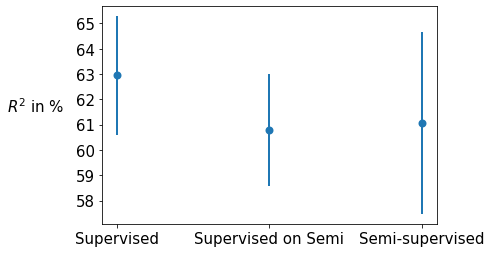

In [8]:
fontsize = 15

r2_lists = [r2_list, r2_s_list, r2_semi_list]
plt.errorbar(
    x=[1,2,3],
    y=[np.mean(x)*100 for x in r2_lists],
    yerr=[np.std(x)*100 for x in r2_lists],
    marker=".",
    mew=5,
    linewidth=0,
    elinewidth=2,)
plt.ylabel("$R^2$ in %", fontsize=fontsize, rotation=0, labelpad=40)
plt.xticks([1, 2, 3], ["Supervised", "Supervised on Semi", "Semi-supervised"], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()